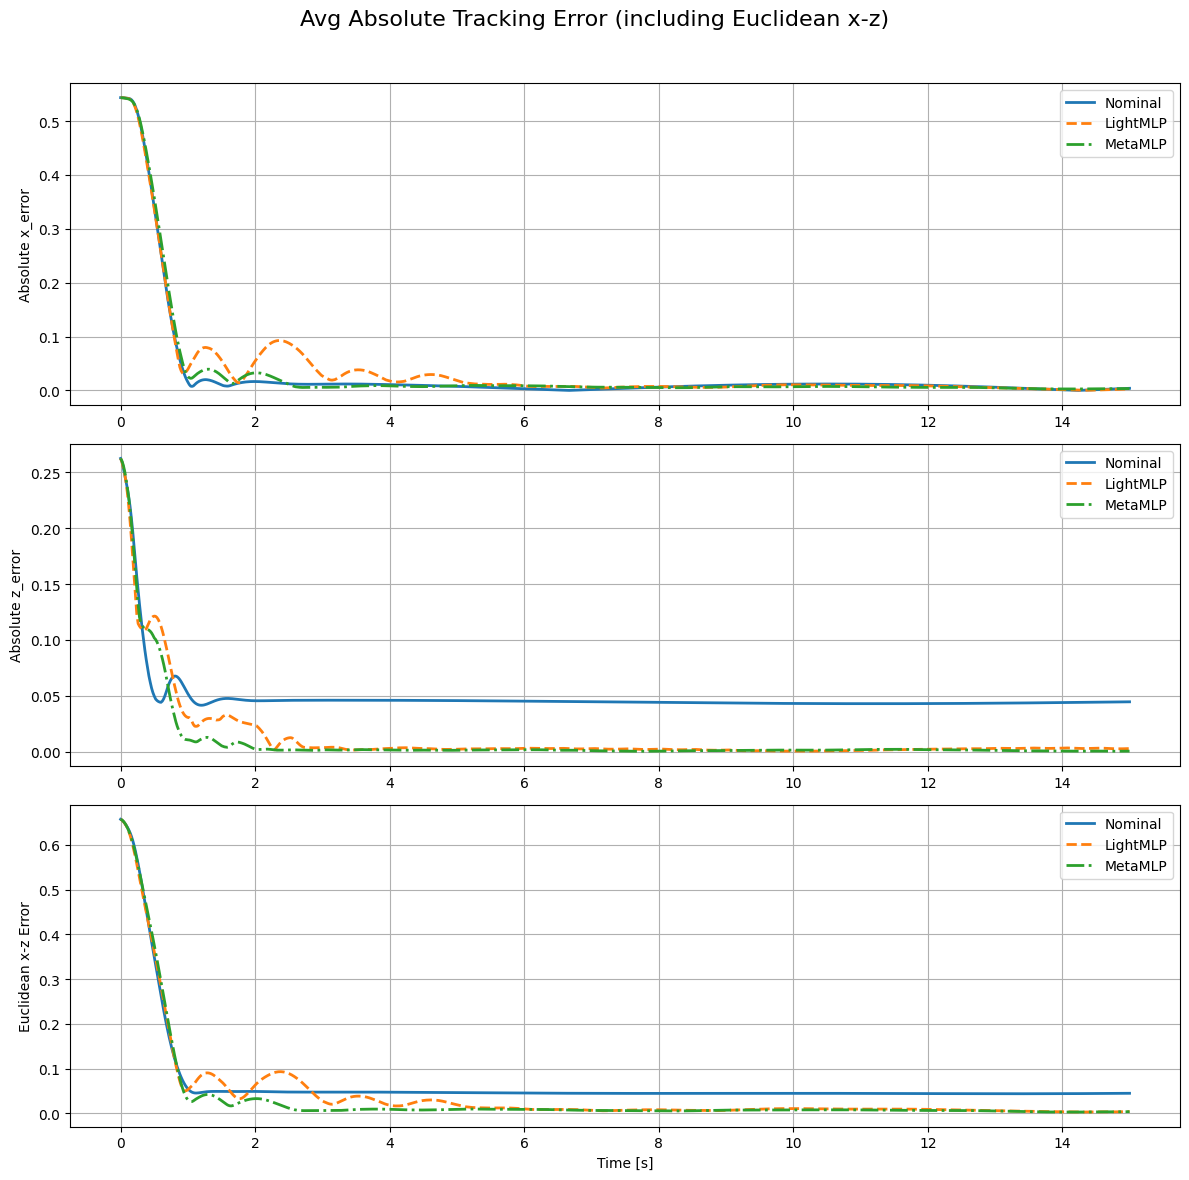

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Configuration
results_dir = "results"
seeds = np.arange(31, 51)
variables = ["x", "z"]  # Removed "theta"

# File groups
nominal_files   = [f"nominal_seed{seed}.csv" for seed in seeds]
lightmlp_files  = [f"lightmlp_seed{seed}.csv" for seed in seeds]
metamlp_files   = [f"metamlp_seed{seed}.csv" for seed in seeds]  # ✅ NEW

# ------------------------------------------------------------------------------
def load_csv_group(filenames):
    dataframes = []
    for fname in filenames:
        path = os.path.join(results_dir, fname)
        if os.path.exists(path):
            df = pd.read_csv(path)
            dataframes.append(df)
        else:
            print(f"Warning: {fname} not found.")
    return dataframes

def compute_avg_abs_error(dataframes, variables):
    min_len = min(len(df) for df in dataframes)
    dataframes = [df.iloc[:min_len] for df in dataframes]
    time = dataframes[0]["time"].values
    avg_abs_error = {}

    for var in variables:
        ref_var = f"{var}_ref"
        if ref_var not in dataframes[0].columns:
            print(f"Warning: Reference column {ref_var} not found in data.")
            continue
        stacked_errors = np.stack([
            np.abs(df[var].values - df[ref_var].values)
            for df in dataframes
        ], axis=0)
        avg_abs_error[var] = np.mean(stacked_errors, axis=0)

    return time, avg_abs_error

# ------------------------------------------------------------------------------
# Compute Euclidean x-z error
def compute_euclidean_error(dataframes):
    min_len = min(len(df) for df in dataframes)
    dataframes = [df.iloc[:min_len] for df in dataframes]
    errors = []

    for df in dataframes:
        x_err = df["x"] - df["x_ref"]
        z_err = df["z"] - df["z_ref"]
        euclidean = np.sqrt(x_err**2 + z_err**2)
        errors.append(euclidean.values)

    errors = np.stack(errors, axis=0)
    avg_euclidean = np.mean(errors, axis=0)
    return avg_euclidean

# ------------------------------------------------------------------------------
# Load and compute
nominal_dfs   = load_csv_group(nominal_files)
lightmlp_dfs  = load_csv_group(lightmlp_files)
metamlp_dfs   = load_csv_group(metamlp_files)  # ✅ NEW

time, avg_abs_nominal  = compute_avg_abs_error(nominal_dfs, variables)
_,    avg_abs_lightmlp = compute_avg_abs_error(lightmlp_dfs, variables)
_,    avg_abs_metamlp  = compute_avg_abs_error(metamlp_dfs, variables)  # ✅ NEW

# Euclidean x-z error
avg_euclidean_nominal  = compute_euclidean_error(nominal_dfs)
avg_euclidean_lightmlp = compute_euclidean_error(lightmlp_dfs)
avg_euclidean_metamlp  = compute_euclidean_error(metamlp_dfs)

# ------------------------------------------------------------------------------
# Plot comparison including Euclidean x-z error
plt.figure(figsize=(12, 4 * (len(variables) + 1)))  # +1 for extra plot

for i, var in enumerate(variables):
    if var not in avg_abs_nominal:
        continue
    plt.subplot(len(variables) + 1, 1, i + 1)
    plt.plot(time, avg_abs_nominal[var], label="Nominal", linewidth=2)
    plt.plot(time, avg_abs_lightmlp[var], label="LightMLP", linewidth=2, linestyle='--')
    plt.plot(time, avg_abs_metamlp[var], label="MetaMLP", linewidth=2, linestyle='-.')
    plt.ylabel(f"Absolute {var}_error")
    plt.grid()
    plt.legend()

# Plot Euclidean error at the end
plt.subplot(len(variables) + 1, 1, len(variables) + 1)
plt.plot(time, avg_euclidean_nominal, label="Nominal", linewidth=2)
plt.plot(time, avg_euclidean_lightmlp, label="LightMLP", linewidth=2, linestyle='--')
plt.plot(time, avg_euclidean_metamlp, label="MetaMLP", linewidth=2, linestyle='-.')
plt.ylabel("Euclidean x-z Error")
plt.grid()
plt.legend()

plt.xlabel("Time [s]")
plt.suptitle("Avg Absolute Tracking Error (including Euclidean x-z)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

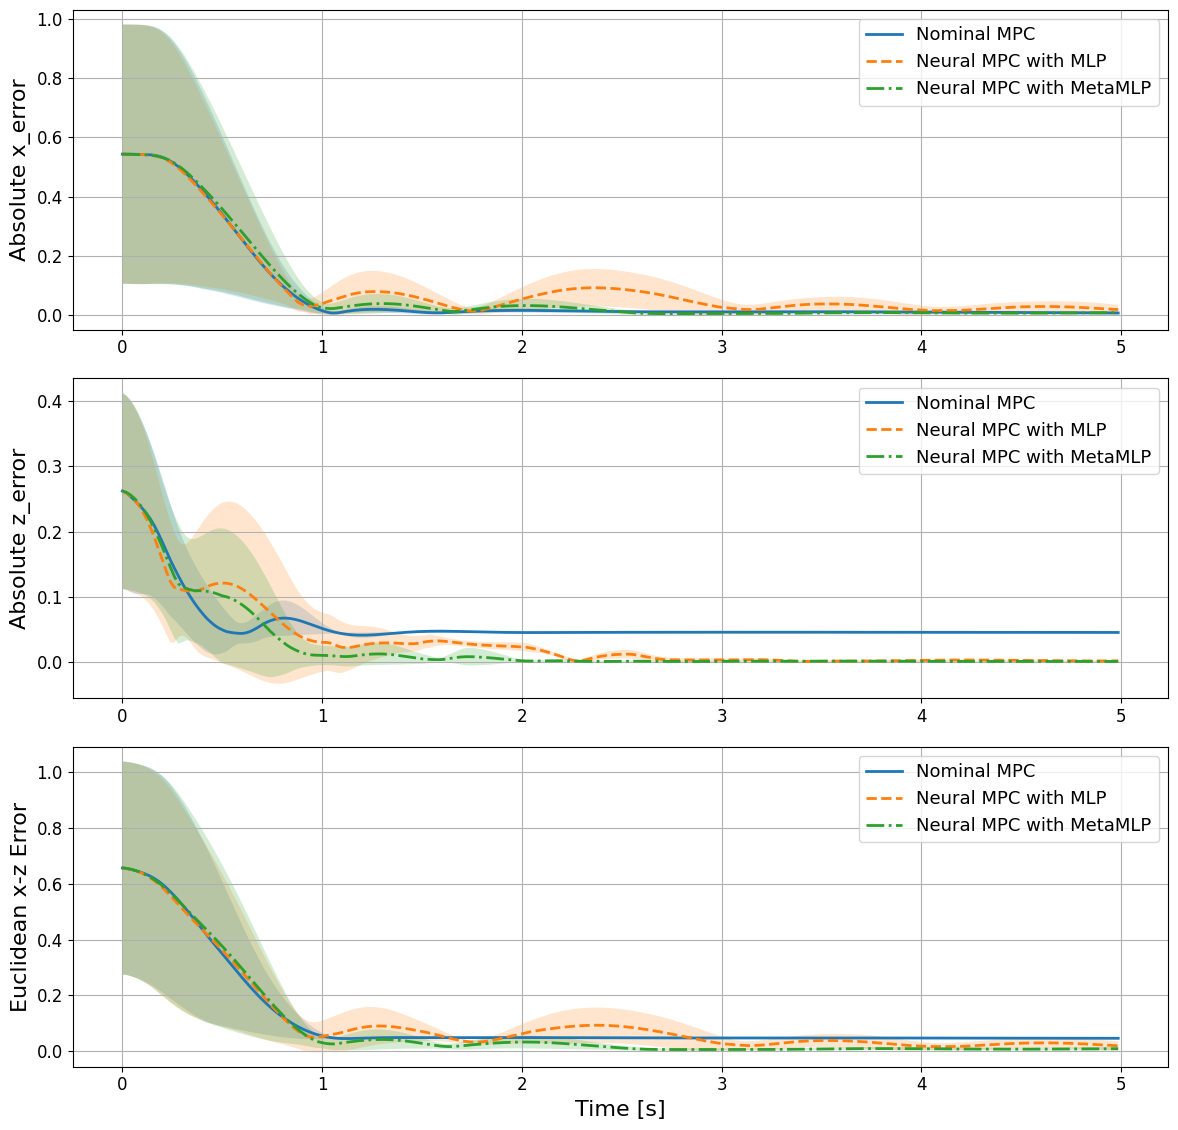

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Configuration
results_dir = "results"
seeds = np.arange(31, 51)
variables = ["x", "z"]
time_limit = 5.0  # ⏱️ Limit plotting to 6 seconds

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

# ------------------------------------------------------------------------------
# File groups
nominal_files   = [f"nominal_seed{seed}.csv" for seed in seeds]
lightmlp_files  = [f"lightmlp_seed{seed}.csv" for seed in seeds]
metamlp_files   = [f"metamlp_seed{seed}.csv" for seed in seeds]

# ------------------------------------------------------------------------------
def load_csv_group(filenames):
    dataframes = []
    for fname in filenames:
        path = os.path.join(results_dir, fname)
        if os.path.exists(path):
            df = pd.read_csv(path)
            dataframes.append(df)
        else:
            print(f"Warning: {fname} not found.")
    return dataframes

def compute_avg_std_abs_error(dataframes, variables):
    min_len = min(len(df) for df in dataframes)
    dataframes = [df.iloc[:min_len] for df in dataframes]
    time = dataframes[0]["time"].values
    avg_abs_error = {}
    std_abs_error = {}

    for var in variables:
        ref_var = f"{var}_ref"
        if ref_var not in dataframes[0].columns:
            print(f"Warning: Reference column {ref_var} not found in data.")
            continue
        stacked_errors = np.stack([
            np.abs(df[var].values - df[ref_var].values)
            for df in dataframes
        ], axis=0)
        avg_abs_error[var] = np.mean(stacked_errors, axis=0)
        std_abs_error[var] = np.std(stacked_errors, axis=0)

    return time, avg_abs_error, std_abs_error

def compute_avg_std_euclidean_error(dataframes):
    min_len = min(len(df) for df in dataframes)
    dataframes = [df.iloc[:min_len] for df in dataframes]
    time = dataframes[0]["time"].values
    errors = []

    for df in dataframes:
        x_err = df["x"] - df["x_ref"]
        z_err = df["z"] - df["z_ref"]
        euclidean = np.sqrt(x_err**2 + z_err**2)
        errors.append(euclidean.values)

    errors = np.stack(errors, axis=0)
    return time, np.mean(errors, axis=0), np.std(errors, axis=0)

def truncate_at_time_limit(time_full, *arrays):
    mask = time_full <= time_limit
    return time_full[mask], [arr[:len(mask)][mask] for arr in arrays]

# ------------------------------------------------------------------------------
# Load and compute
nominal_dfs   = load_csv_group(nominal_files)
lightmlp_dfs  = load_csv_group(lightmlp_files)
metamlp_dfs   = load_csv_group(metamlp_files)

# Absolute error
time_full, avg_abs_nominal, std_abs_nominal   = compute_avg_std_abs_error(nominal_dfs, variables)
_,          avg_abs_lightmlp, std_abs_lightmlp = compute_avg_std_abs_error(lightmlp_dfs, variables)
_,          avg_abs_metamlp, std_abs_metamlp   = compute_avg_std_abs_error(metamlp_dfs, variables)

# Euclidean error
time_full, avg_euclidean_nominal, std_euclidean_nominal   = compute_avg_std_euclidean_error(nominal_dfs)
_,         avg_euclidean_lightmlp, std_euclidean_lightmlp = compute_avg_std_euclidean_error(lightmlp_dfs)
_,         avg_euclidean_metamlp, std_euclidean_metamlp   = compute_avg_std_euclidean_error(metamlp_dfs)

# ------------------------------------------------------------------------------
# Truncate at time_limit
time, [
    avg_euclidean_nominal,
    std_euclidean_nominal,
    avg_euclidean_lightmlp,
    std_euclidean_lightmlp,
    avg_euclidean_metamlp,
    std_euclidean_metamlp,
] = truncate_at_time_limit(
    time_full,
    avg_euclidean_nominal,
    std_euclidean_nominal,
    avg_euclidean_lightmlp,
    std_euclidean_lightmlp,
    avg_euclidean_metamlp,
    std_euclidean_metamlp,
)

for var in variables:
    _, [
        avg_abs_nominal[var],
        std_abs_nominal[var],
        avg_abs_lightmlp[var],
        std_abs_lightmlp[var],
        avg_abs_metamlp[var],
        std_abs_metamlp[var],
    ] = truncate_at_time_limit(
        time_full,
        avg_abs_nominal[var],
        std_abs_nominal[var],
        avg_abs_lightmlp[var],
        std_abs_lightmlp[var],
        avg_abs_metamlp[var],
        std_abs_metamlp[var],
    )

# ------------------------------------------------------------------------------
# Plot
plt.figure(figsize=(12, 4 * (len(variables) + 1)))

for i, var in enumerate(variables):
    plt.subplot(len(variables) + 1, 1, i + 1)

    plt.plot(time, avg_abs_nominal[var], label="Nominal MPC", linewidth=2)
    plt.fill_between(time,
                     avg_abs_nominal[var] - std_abs_nominal[var],
                     avg_abs_nominal[var] + std_abs_nominal[var],
                     alpha=0.2)

    plt.plot(time, avg_abs_lightmlp[var], label="Neural MPC with MLP", linewidth=2, linestyle='--')
    plt.fill_between(time,
                     avg_abs_lightmlp[var] - std_abs_lightmlp[var],
                     avg_abs_lightmlp[var] + std_abs_lightmlp[var],
                     alpha=0.2)

    plt.plot(time, avg_abs_metamlp[var], label="Neural MPC with MetaMLP", linewidth=2, linestyle='-.')
    plt.fill_between(time,
                     avg_abs_metamlp[var] - std_abs_metamlp[var],
                     avg_abs_metamlp[var] + std_abs_metamlp[var],
                     alpha=0.2)

    plt.ylabel(f"Absolute {var}_error", fontsize=16)
    plt.grid()
    plt.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# Euclidean Error subplot
plt.subplot(len(variables) + 1, 1, len(variables) + 1)
plt.plot(time, avg_euclidean_nominal, label="Nominal MPC", linewidth=2)
plt.fill_between(time,
                 avg_euclidean_nominal - std_euclidean_nominal,
                 avg_euclidean_nominal + std_euclidean_nominal,
                 alpha=0.2)

plt.plot(time, avg_euclidean_lightmlp, label="Neural MPC with MLP", linewidth=2, linestyle='--')
plt.fill_between(time,
                 avg_euclidean_lightmlp - std_euclidean_lightmlp,
                 avg_euclidean_lightmlp + std_euclidean_lightmlp,
                 alpha=0.2)

plt.plot(time, avg_euclidean_metamlp, label="Neural MPC with MetaMLP", linewidth=2, linestyle='-.')
plt.fill_between(time,
                 avg_euclidean_metamlp - std_euclidean_metamlp,
                 avg_euclidean_metamlp + std_euclidean_metamlp,
                 alpha=0.2)

plt.ylabel("Euclidean x-z Error", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.grid()
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("results/tracking_error_summary.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/tracking_error_summary.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


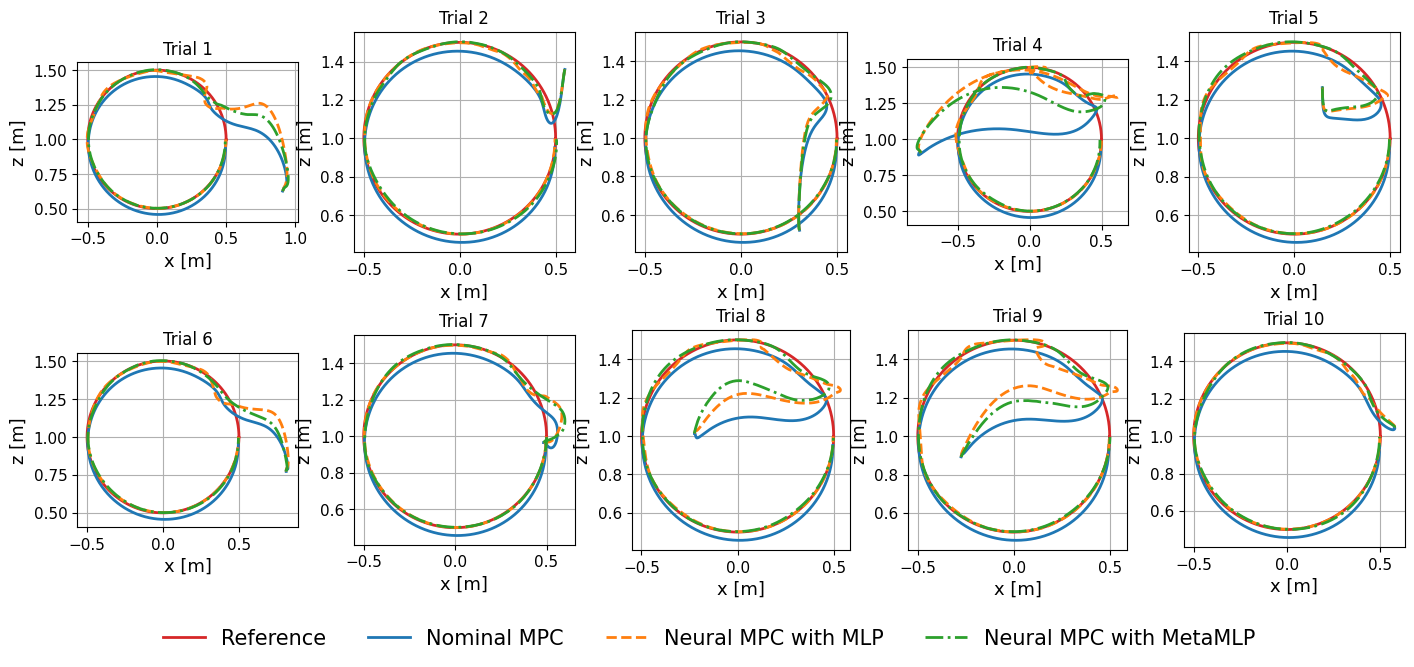

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Configuration
results_dir = "results"
seeds = np.arange(41, 51)  # seeds 41–50
models = ["nominal", "lightmlp", "metamlp"]
colors = {
    "nominal": "C0",
    "lightmlp": "C1",
    "metamlp": "C2",
    "reference": "C3"
}
linestyles = {
    "nominal": "-",
    "lightmlp": "--",
    "metamlp": "-.",
    "reference": "-"
}
model_labels = {
    "nominal": "Nominal MPC",
    "lightmlp": "Neural MPC with MLP",
    "metamlp": "Neural MPC with MetaMLP",
    "reference": "Reference"
}

# ------------------------------------------------------------------------------
# Load and plot x-z trajectories
fig, axs = plt.subplots(2, 5, figsize=(18, 7))  # 10 subplots (2 rows x 5 cols)
axs = axs.flatten()

# Keep track of lines for unified legend
legend_handles = {}

for idx, seed in enumerate(seeds):
    ax = axs[idx]
    reference_plotted = False

    for model in models:
        fname = f"{model}_seed{seed}.csv"
        path = os.path.join(results_dir, fname)
        if not os.path.exists(path):
            print(f"Warning: {fname} not found.")
            continue
        df = pd.read_csv(path)

        # Plot reference once per subplot
        if not reference_plotted and "x_ref" in df.columns and "z_ref" in df.columns:
            (ref_line,) = ax.plot(
                df["x_ref"], df["z_ref"],
                color=colors["reference"],
                linestyle=linestyles["reference"],
                linewidth=2,
                label=model_labels["reference"]
            )
            legend_handles["reference"] = ref_line
            reference_plotted = True

        # Plot actual trajectory
        (model_line,) = ax.plot(
            df["x"], df["z"],
            color=colors[model],
            linestyle=linestyles[model],
            linewidth=2,
            label=model_labels[model]
        )
        legend_handles[model] = model_line

    ax.set_title(f"Trial {seed-40}", fontsize=12)
    ax.set_xlabel("x [m]", fontsize=13)
    ax.set_ylabel("z [m]", fontsize=13)
    ax.tick_params(labelsize=11)
    ax.set_aspect("equal")
    ax.grid()

# Remove unused axes if any
for j in range(len(seeds), len(axs)):
    fig.delaxes(axs[j])

# ------------------------------------------------------------------------------
# Unified Legend (BIGGER font)
fig.legend(
    handles=[legend_handles[k] for k in ["reference", "nominal", "lightmlp", "metamlp"]],
    labels=[model_labels[k] for k in ["reference", "nominal", "lightmlp", "metamlp"]],
    loc="lower center",
    ncol=4,
    fontsize=15,  # <-- Bigger font here
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

# Tight layout & save high-quality
plt.tight_layout(rect=[0.1, 0.05, 0.9, 0.95])
plt.subplots_adjust(wspace=0.25, hspace=0.35)

# Save high-quality versions
plt.savefig("results/xz_trajectories_comparison.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/xz_trajectories_comparison.png", format="png", dpi=300, bbox_inches="tight")

plt.show()
